In [209]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [245]:
PATH_HEAD = r'C:\Users\猛\Desktop\yoshiki_study\normalizing_flow'
path_input = PATH_HEAD + '/result/210318_122922' # volatirity only
#path_input = PATH_HEAD + '/result/210318_125139' # volatirily + arbi
#path_input = PATH_HEAD + '/result/210318_131145' # all

target_names = ['S&P500', 'TOPIX', 'UST', 'JGB']
rename_dict = dict(zip(['Treasury_JPY', 'SPX_JPY', 'TPXDDVD Index', 'SPJGBTR Index'], target_names))
color_list = ['red', 'blue', 'green', 'goldenrod']
color_discrete_map= dict(zip(target_names, color_list))

df_target = pd.read_csv(path_input+'/df_org.csv').set_index('Date').rename(columns=rename_dict)
mean_all = pd.read_csv(path_input+'/mean_all.csv').set_index('Date').rename(columns=rename_dict)
sd_all = pd.read_csv(path_input+'/sd_all.csv').set_index('Date').rename(columns=rename_dict)
weight_all = pd.read_csv(path_input+'/weight_all.csv').set_index('Date').rename(columns=rename_dict)

In [211]:
df_target_, mean_all_ = df_target.copy(), mean_all.copy()
df_target_['type'] = 'true'
mean_all_['type'] = 'predict'
df_merged = pd.concat([df_target_, mean_all_], axis=0)
df_merged

S&P500     TOPIX       UST       JGB     type
Date                                                       
2003-05-30  0.020867  0.053938  0.014036  0.004111     true
2003-06-06 -0.004930  0.020049  0.038089  0.000945     true
2003-06-13  0.006704 -0.009181  0.013436  0.001337     true
2003-06-20 -0.010491  0.015276  0.019781 -0.010211     true
2003-06-27  0.000017 -0.008709  0.005072 -0.006666     true
...              ...       ...       ...       ...      ...
2019-08-16  0.007127 -0.001830  0.005011  0.001450  predict
2019-08-23  0.007453 -0.001085  0.005879  0.001355  predict
2019-08-30  0.007303 -0.000254  0.008775  0.001000  predict
2019-09-06  0.007058 -0.000861  0.007379  0.001269  predict
2019-09-13  0.005948 -0.000268  0.008530  0.000991  predict

[1470 rows x 5 columns]

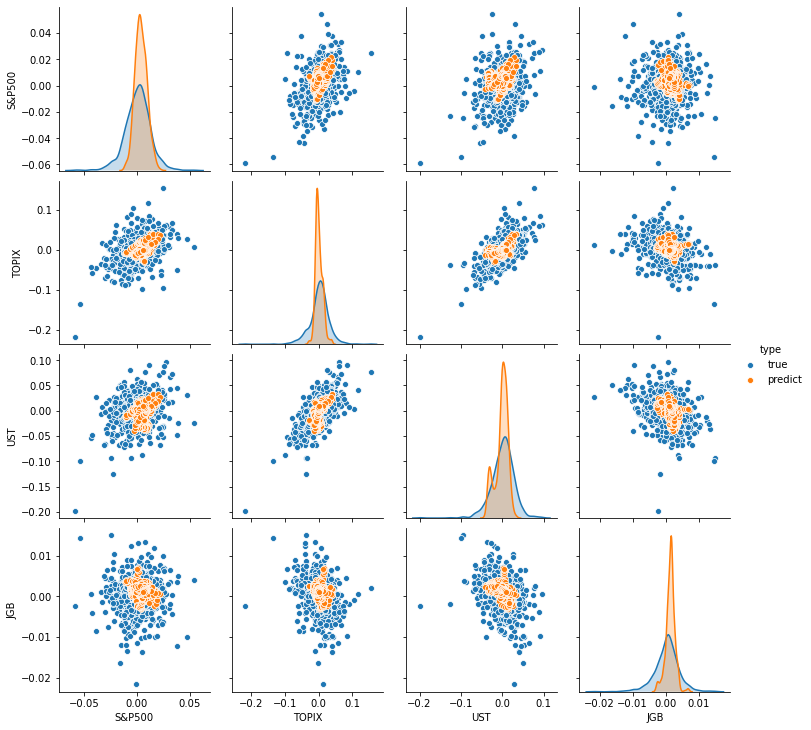

In [212]:
sns.pairplot(df_merged, hue='type')

In [213]:
# index_test = mean_all.index
# fig = px.line(df_target.loc[index_test], y=df_target.columns, title='return')
# fig.update_xaxes(tickformat="%b\n%Y")

In [258]:
# fig = px.line(mean_all, y=df_target.columns, color=fi, title='mean(predict)')
# fig.update_xaxes(tickformat="%b\n%Y")

## 予測リターンの推移

In [265]:
fig = go.Figure([
    go.Scatter(
        x=mean_all.index, y=mean_all[mean_all.columns[i]],
        opacity=.5,
        name=mean_all.columns[i],
        #color=color_discrete_map[name_i]        
    )
    for i, name_i in enumerate(mean_all.columns)
])
fig.update_xaxes(tickformat="%b\n%Y")
fig.update_xaxes(tickformat="%b\n%Y")

fig.show()

## 50週リターン移動平均

In [267]:
roll_window = 50
df_target_r = df_target.rolling(roll_window).mean().loc[index_test]

fig = go.Figure([
    go.Scatter(
        x=df_target_r.index, y=df_target_r[df_target_r.columns[i]],
        opacity=.5,
        name=mean_all.columns[i],
        #color=color_discrete_map[name_i]        
    )
    for i, name_i in enumerate(df_target_r.columns)
])
fig.update_xaxes(tickformat="%b\n%Y")
fig.update_xaxes(tickformat="%b\n%Y")

fig.show()

## 50週ヒストリカルボラティリティ（共変量）の推移

In [270]:
roll_window = 50
df_target_vol = df_target.rolling(roll_window).std().loc[index_test]

In [271]:
# from plotly.subplots import make_subplots
# fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
# name = ['predict', 'volatility(20-days)']

fig = go.Figure([
    go.Scatter(
        x=df_target_vol.index, y=df_target_vol[df_target_vol.columns[i]],
        opacity=.5,
        name=df_target_vol.columns[i],
        #color=color_discrete_map[name_i]        
    )
    for i, name_i in enumerate(df_target_vol.columns)
])
fig.update_xaxes(tickformat="%b\n%Y")

fig.show()

## 予測分布のボラティリティ

In [257]:
# from plotly.subplots import make_subplots
# fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
# name = ['predict', 'volatility(20-days)']

fig = go.Figure([
    go.Scatter(
        x=sd_all.index, y=sd_all[sd_all.columns[i]],
        opacity=.5,
        name=sd_all.columns[i],
        #color=color_discrete_map[name_i]        
    )
    for i, name_i in enumerate(sd_all.columns)
])
fig.update_xaxes(tickformat="%b\n%Y")

fig.show()

In [250]:
df_ = mean_all
normed_area_fig = go.Figure()

for i, name_i in enumerate(weight_all.columns):
    normed_area_fig.add_trace(
        go.Scatter(
            x=weight_all.index,
            y=weight_all[name_i],
            stackgroup="groupA",  # 同じ名前の要素が積み上げられる
            mode="none",
            groupnorm="fraction",  # ❶ 合計を1として正規化
            name=name_i,
#            fillcolor=color_discrete_map[name_i]            
            #fillcolor=i,
        )
    )
normed_area_fig.update_xaxes(tickformat="%b\n%Y")    
normed_area_fig.show()

### 過去のリターン/ボラベースでのシャープレシオ最大化

In [272]:
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
window = 52
window_max = len(index_test) - window
hist_mean = df_target.rolling(window).mean().loc[index_test]
hist_cov = df_target.rolling(roll_window).cov().loc[index_test]
weight_test = pd.DataFrame(np.zeros((len(index_test), len(df_target.columns))), index=index_test, columns=df_target.columns)
for t in index_test:
    mean_t = hist_mean.loc[t]
    var_t = hist_cov.loc[t]
    try:
        ef = EfficientFrontier(mean_t, var_t)       
        weight = ef.max_sharpe(risk_free_rate=0)
        weight_test.loc[t] = list(weight.values())
    except:
        weight_test.loc[t] = [np.nan for _ in range(len(df_target.columns))]

In [273]:
normed_area_fig = go.Figure()

for i, name_i in enumerate(weight_test.columns):
    normed_area_fig.add_trace(
        go.Scatter(
            x=weight_test.index,
            y=weight_test[name_i],
            stackgroup="groupA",  # 同じ名前の要素が積み上げられる
            mode="none",
            groupnorm="fraction",  # ❶ 合計を1として正規化
            name=name_i,
#            fillcolor=i,
        )
    )
normed_area_fig.show()